# <center> MATH&ML-12. Временные ряды. Часть I
---

### 3. Тренд, сезонность, шум. Инструменты для декомпозиции временного ряда

##### ИНСТРУМЕНТЫ ДЛЯ ДЕКОМПОЗИЦИИ ВРЕМЕННОГО РЯДА

In [1]:
import pandas as pd 
df = pd.read_csv("data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])

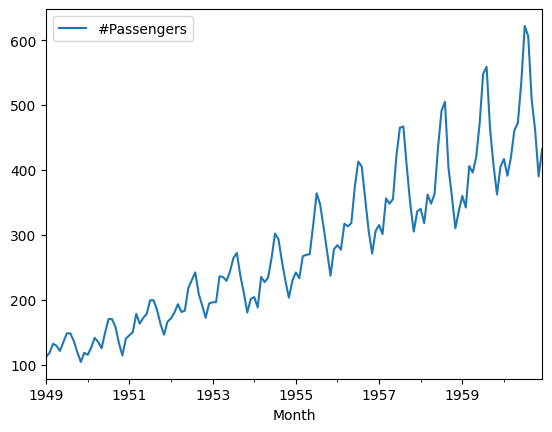

In [2]:
df.plot(kind='line');

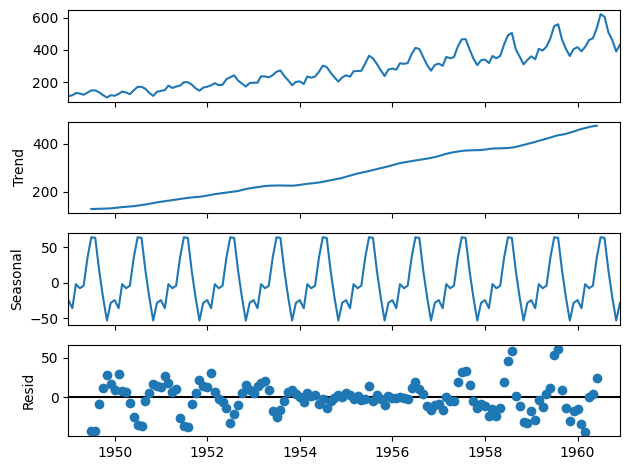

In [3]:
import matplotlib.pyplot as plt
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

---
### 4. Экспоненциальное сглаживание

In [4]:
import numpy as np

def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(6)
s[0] = data[0]

for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])

print(s)

[15.      18.5     23.05    27.915   25.8745  26.66235]


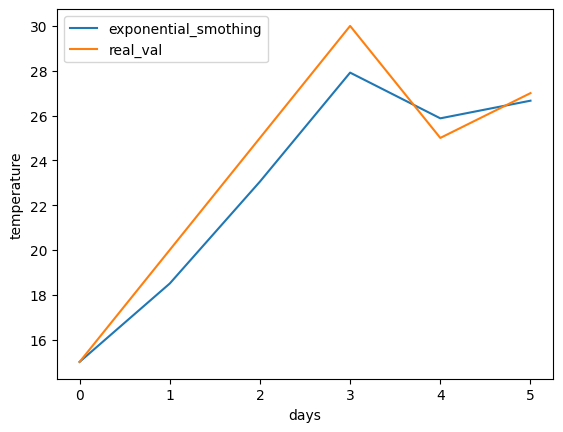

In [5]:
fig, ax = plt.subplots()
pd.Series(s).plot(label='exponential_smothing')
pd.Series(data).plot(label='real_val')
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('temperature')
plt.show()

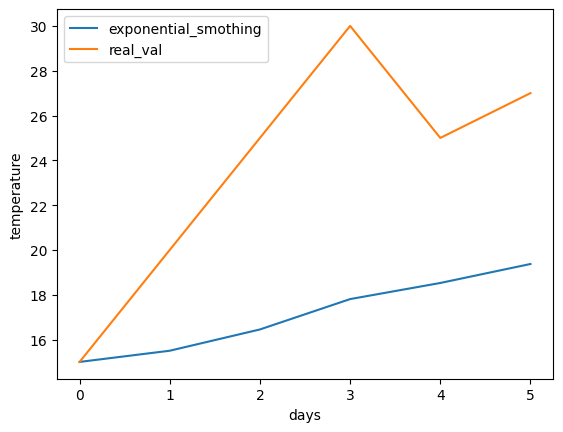

In [6]:
s = np.zeros(6)
s[0] = data[0]
a = 0.1
for i in range(1, len(data)):
    s[i] = exp_smth(data[i], a, s[i-1])
    
fig, ax = plt.subplots()
pd.Series(s).plot(label='exponential_smothing')
pd.Series(data).plot(label='real_val')
ax.legend()
ax.set_xlabel('days')
ax.set_ylabel('temperature')
plt.show()

In [7]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

[26.66235]


---
### 5. Стационарность

##### СТАТИСТИЧЕСКИЕ ТЕСТЫ НА PYTHON

In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.csv", 
    header=0, 
    index_col=0
).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -4.808291253559763
p-value: 5.243412990149865e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

Для определения порядка интегрированного ряда необходимо сделать следующее:

1. Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):

In [9]:
df_diff_1 = df.diff().dropna()

2. Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):

In [10]:
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -12.625178633871343
p-value:  1.5472400091969784e-23
Critical values:  {'1%': np.float64(-3.44880082033912), '5%': np.float64(-2.869670179576637), '10%': np.float64(-2.5711012838861036)}
ряд стационарен


---
### 6. Автокорреляция

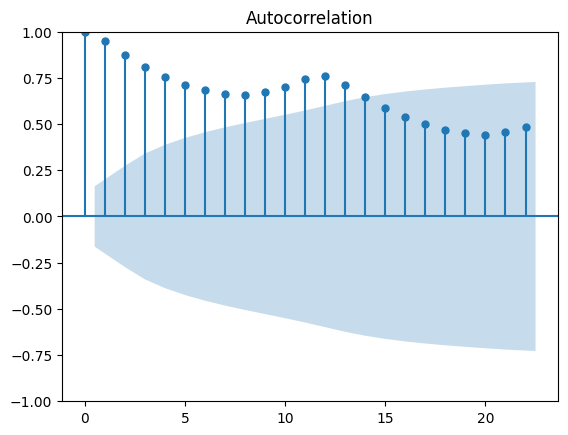

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv("data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])
plot_acf(df);

---
### 7. Авторегрессия

##### AR-МОДЕЛИРОВАНИЕ НА PYTHON

* `Date` — дата (в формате гггг-мм-дд);
* `Consumption` — потребление электроэнергии (ГВтч);
* `Wind` — производство ветровой энергии (ГВтч);
* `Solar` — производство солнечной энергии (ГВтч);
* `Wind+Solar` — сумма производства ветровой и солнечной энергии (ГВтч).

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, sep=",")

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Consumption'].values)

if result[0] > result[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

Ряд стационарен


In [14]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

In [15]:
ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Tue, 19 Nov 2024   AIC                          48483.625
Time:                        11:34:52   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

In [16]:
pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

---
### 8. Итоговая практика

* `date` — дата заказа;
* `quantity` (qty) — количество книг, заказанных в этот день.

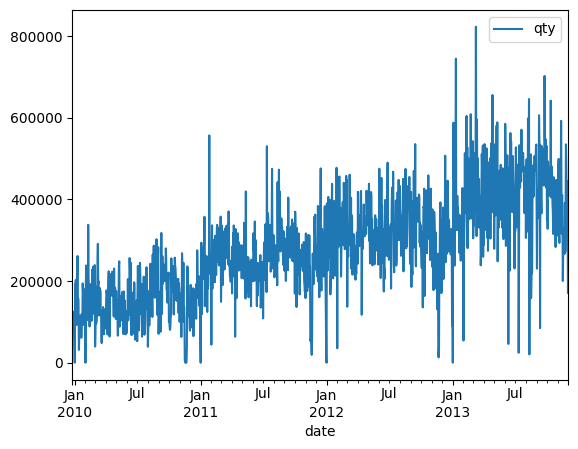

In [17]:
# Загрузите датасет и выполните следующие шаги
data = (pd.read_csv('data/tovar_moving.csv', index_col='date', parse_dates=['date'])
          .asfreq('D'))
data.plot();

In [18]:
# 1. Отложите в test последнее значение временного ряда
train_data = data.iloc[:-1]
test_data = data.iloc[-1]

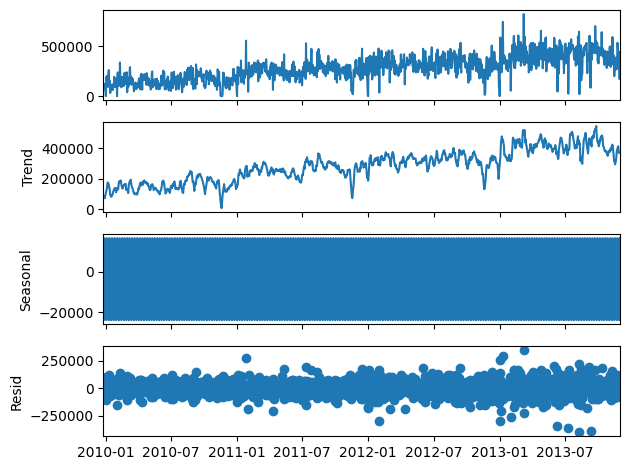

In [19]:
# 2. Проанализируйте временной ряд на наличие тренда и сезонности
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(data)
sd.plot();

In [20]:
# 3. Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (alpha=0.7)
# Сравните результат с фактическим значением, которое вы отложили вначале
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_data)
alpha = 0.7
model = ses.fit(smoothing_level=alpha, optimized=False)
forecast = model.forecast(1)
print(f'forecast = {forecast.iloc[0]:.2f}\ntest_data = {test_data.iloc[0]:.2f}')

forecast = 225015.52
test_data = 423846.00


In [21]:
# 4. Проверьте ряд на стационарность, определите порядок интегрирования
from statsmodels.tsa.stattools import adfuller

def get_stationarity(data, i=0):
    data = data.dropna()
    
    adf = adfuller(data.values)
    print(f'\nADF Statistics: {adf[0]}')
    print(f'p-value: {adf[1]}')
    print(f'Critical Values:')
    for key, value in adf[4].items():
        print(f'\t{key}: {value:.3f}')
        
    if adf[0] >= adf[4]['5%']:
        data = data.diff()
        return get_stationarity(data, i+1)
    else:
        print(f'\nРяд стационарен на уровне порядка интегрирования {i}')
    return data, i

stat_data, diff_order = get_stationarity(data)


ADF Statistics: -2.2379751493990567
p-value: 0.19275239554840862
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

ADF Statistics: -13.821839865226671
p-value: 7.878856681049412e-26
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568

Ряд стационарен на уровне порядка интегрирования 1


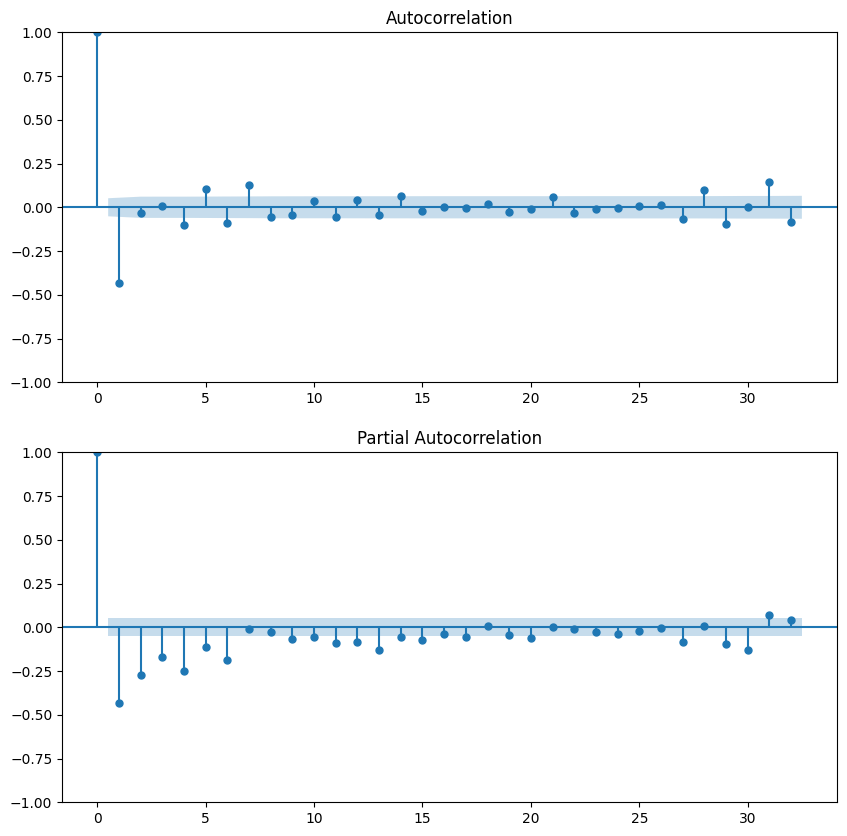

In [36]:
# 5. Определите порядок модели AR по графику частичной автокорреляции
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
plot_acf(stat_data, ax[0])
plot_pacf(stat_data, ax[1])
plt.show()

In [143]:
# 6. Постройте модель AR и предскажите последнее значение ряда
from statsmodels.tsa.ar_model import AutoReg
arm = AutoReg(train_data, lags=6).fit()
pred = arm.predict(start=len(train_data), end=(len(data)-1), dynamic=False)
print(f'forecast = {pred.iloc[0]:.2f}\ntest_data = {test_data.iloc[0]:.2f}')

forecast = 318174.28
test_data = 423846.00
